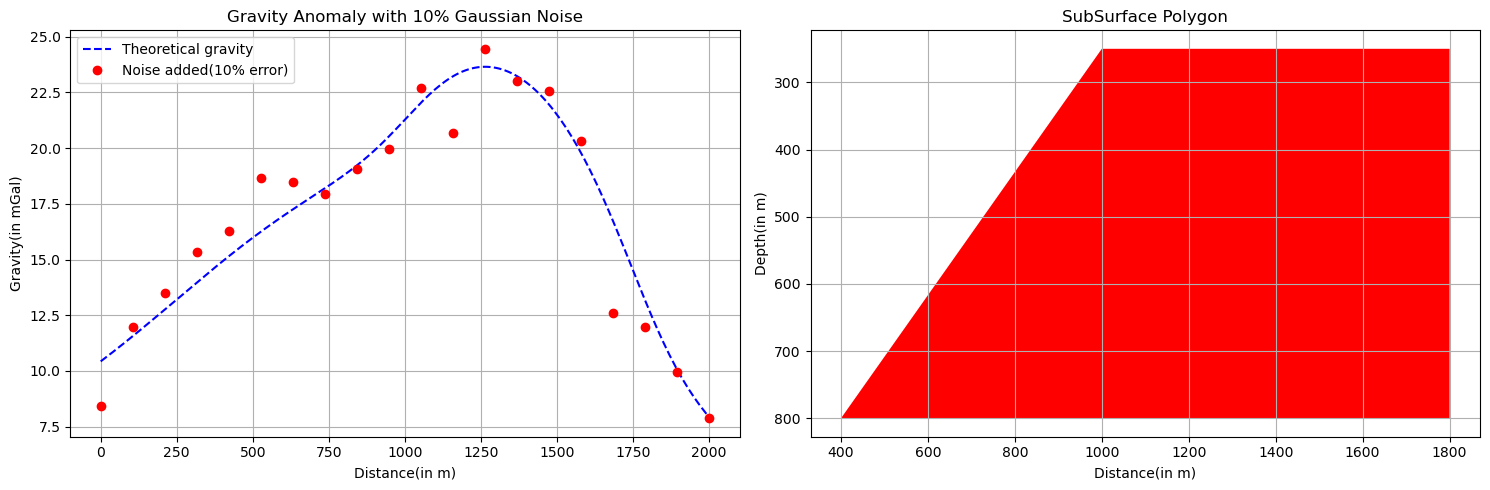

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def polygon_gravity (x_obs,polygon_vertices, density_contrast=0.3):
    gamma = 6.67e-11
    si2mgal = 1e5
    rho = density_contrast*1000

    xv,zv = polygon_vertices[:,0],polygon_vertices[:,1]
    grav = np.zeros_like(x_obs)

    for i in range(len(xv)):
        x1,z1 = xv[i], zv[i]
        x2,z2 = xv[(i+1)%len(xv)], zv[(i+1)%len(zv)]
    

        dx = x2-x1
        dz = z2-z1
        r1_sq = (x_obs - x1)**2 + z1**2
        r2_sq = (x_obs - x2)**2 + z2**2

        term = dz*np.log(r2_sq/r1_sq) - 2*dx*(np.arctan2(z2,x_obs-x2)-np.arctan2(z1,x_obs-x1))
        grav += term*2*gamma*rho

    return -grav*si2mgal


#POLYGON VERTICES
x_poly = np.array([400,727.27,1000,1800,1800,400])
z_poly = np.array([800,500,250,250,800,800])
polygon = np.column_stack((x_poly,z_poly))

#OBSERVATION POINTS
x_min,x_max = 0,2001
x_obs_fine = np.arange(x_min,x_max,10,dtype=np.float64)
x_obs_points = np.linspace(x_min,x_max,20)
density = 0.3

#GRAVITY CALCULATION
g_smooth = polygon_gravity(x_obs_fine,polygon,density)
g_true_points = polygon_gravity(x_obs_points,polygon,density)

#ADDING 10% GAUSSIAN NOISE
noise_magnitude = 0.1*np.abs(g_true_points)
g_noisy_points = g_true_points+np.random.normal(0,noise_magnitude)

#PLOTTING
plt.figure(figsize=(15,5))

#GRAVITY ANOMALY PLOT
plt.subplot(1,2,1)
plt.plot(x_obs_fine,g_smooth,'b--',label='Theoretical gravity')
plt.plot(x_obs_points,g_noisy_points,'ro',label='Noise added(10% error)')
plt.xlabel('Distance(in m)')
plt.ylabel('Gravity(in mGal)')
plt.title('Gravity Anomaly with 10% Gaussian Noise')
plt.legend()
plt.grid(True)

#SUBSURFACE POLYGON PLOT
plt.subplot(1,2,2)
poly_closed=np.vstack((polygon,polygon[0]))
plt.fill(poly_closed[:,0],poly_closed[:,1],'red',linewidth=2)
plt.xlabel('Distance(in m)')
plt.ylabel('Depth(in m)')
plt.title('SubSurface Polygon')
plt.gca().invert_yaxis()
plt.grid(True)

plt.tight_layout()
plt.show()


Iter 1: MSE = 2.3261
Iter 2: MSE = 1.7366
Iter 3: MSE = 0.6906
Iter 4: MSE = 0.6906
Iter 5: MSE = 0.6906
Iter 6: MSE = 0.6906
Iter 7: MSE = 0.6670
Iter 8: MSE = 0.6670
Iter 9: MSE = 0.6670
Iter 10: MSE = 0.6670
Iter 11: MSE = 0.6670
Iter 12: MSE = 0.6670
Iter 13: MSE = 0.6669
Iter 14: MSE = 0.6669
Iter 15: MSE = 0.6669


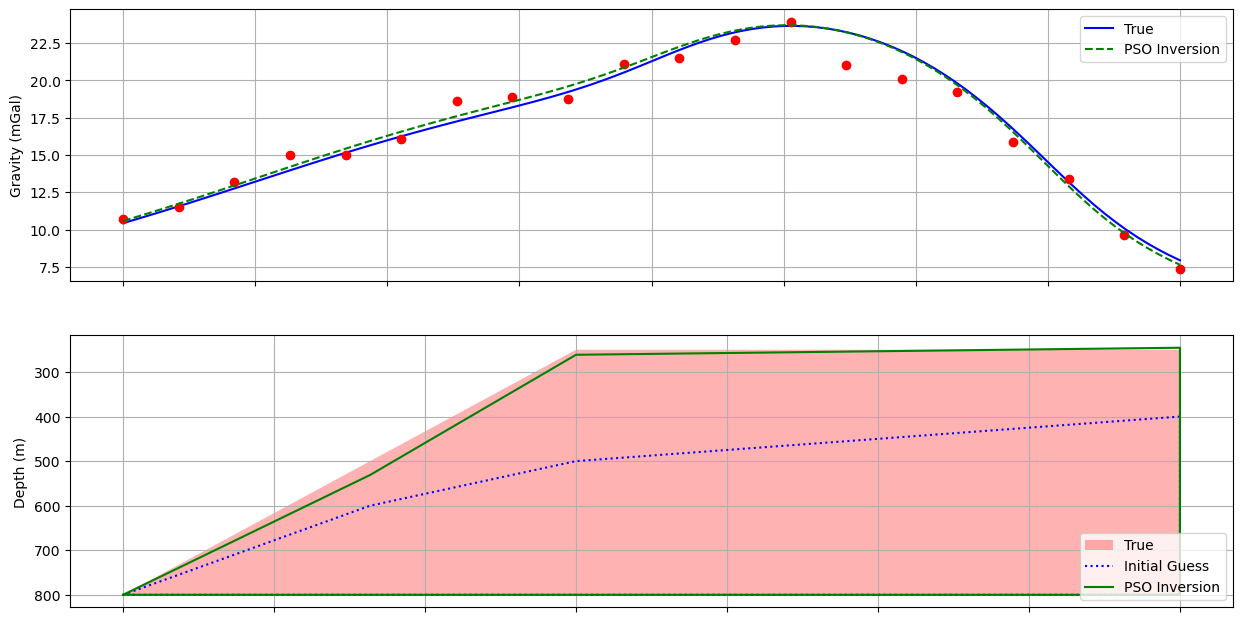

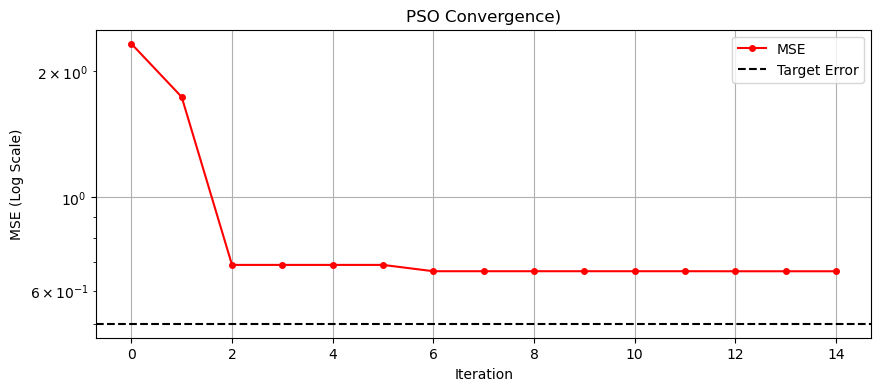

<Figure size 640x480 with 0 Axes>


=== PSO RESULTS ===
Optimized depths: [531.05118875 261.30851144 245.51066196]
True depths: [500.0, 250.0, 250.0]
Final MSE: 0.666876
Iterations: 15


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def polygon_gravity(x_obs, polygon_vertices, density_contrast=0.3):

    gamma = 6.67e-11    
    si2mgal = 1e5      
    rho = density_contrast * 1000  
    
    grav = np.zeros_like(x_obs)
    #Ensure the polygon is closed
    if not np.allclose(polygon_vertices[0], polygon_vertices[-1]):
        polygon_vertices = np.vstack((polygon_vertices, polygon_vertices[0]))
    
    xv, zv = polygon_vertices[:,0], polygon_vertices[:,1]
    
    for i in range(len(xv)-1):
        x1, z1 = xv[i], zv[i]
        x2, z2 = xv[i+1], zv[i+1]
        
        dx = x2 - x1
        dz = z2 - z1
        eps = 1e-10  #to avoid time issue 
        r1_sq = (x_obs - x1 + eps)**2 + (z1 + eps)**2
        r2_sq = (x_obs - x2 + eps)**2 + (z2 + eps)**2
        
        term = dz * np.log(r2_sq/r1_sq) - 2 * dx * (
            np.arctan2(z2, (x_obs - x2 + eps)) - 
            np.arctan2(z1, (x_obs - x1 + eps)))
        grav += term
    
    return -2 * grav * gamma * rho * si2mgal

#fixing the random seed
np.random.seed(42)

true_polygon = np.array([
    [400, 800], 
    [727.27, 500], 
    [1000, 250], 
    [1800, 250], 
    [1800, 800], 
    [400, 800]])

# Observation points
x_obs_fine = np.linspace(0, 2000, 100)  
x_obs_points = np.linspace(0, 2000, 20)  
density = 0.3  # g/cm³


true_gravity = polygon_gravity(x_obs_points, true_polygon, density)
noise = 0.05 * np.abs(true_gravity) * np.random.normal(0, 1, len(true_gravity))
noisy_gravity = true_gravity + noise

# PSO parameters
n_particles = 5
max_iter = 15
w = 0.7      
c1 = 1.5   
c2 = 1.5    
target_error = 0.5

#defining the upper and lower bound.
lb = np.array([400, 200, 100])  
ub = np.array([700, 600, 400])  
n_dim = len(lb)

# Initial guess
initial_guess = np.array([
    [400, 800],
    [727.27, 600],
    [1000, 500],  
    [1800, 400],  
    [1800, 800],
    [400, 800]
])
z_indices = [1, 2, 3]  

# Initialize swarm
particles = np.random.uniform(lb, ub, (n_particles, n_dim))
velocities = np.zeros((n_particles, n_dim))
pbest_positions = particles.copy()
pbest_scores = np.full(n_particles, np.inf)
gbest_position = None
gbest_score = np.inf
error_history = []

def evaluate(particle):
    current_vertices = initial_guess.copy()
    current_vertices[z_indices, 1] = particle
    g_pred = polygon_gravity(x_obs_points, current_vertices, density)
    return np.mean((g_pred - noisy_gravity)**2)


prev_gbest_score = np.inf
tolerance = 1e-6

# PSO main loop
for iteration in range(max_iter):
    for i in range(n_particles):
        score = evaluate(particles[i])
        
        # Update personal best..
        if score < pbest_scores[i]:
            pbest_scores[i] = score
            pbest_positions[i] = particles[i].copy()
        
        # Update global best..
        if score < gbest_score:
            gbest_score = score
            gbest_position = particles[i].copy()
    
    # Update velocity and position
    for i in range(n_particles):
        r1, r2 = np.random.rand(2)
        velocities[i] = (w * velocities[i] +
                         c1 * r1 * (pbest_positions[i] - particles[i]) +
                         c2 * r2 * (gbest_position - particles[i]))
        particles[i] = np.clip(particles[i] + velocities[i], lb, ub)
    
    error_history.append(gbest_score)

    print(f"Iter {iteration + 1}: MSE = {gbest_score:.4f}")
    '''if abs(prev_gbest_score - gbest_score) <= tolerance:
        break
    if gbest_score <= target_error:
        break'''
    
'''# Inside the iteration loop:
    if abs(prev_gbest_score - gbest_score) <= tolerance:
        print(f"Converged at iteration {iteration}. Final MSE: {gbest_score:.4f}")
        break
    # Early stopping
    if gbest_score <= target_error:
        break'''

#final poly
optimized_polygon = initial_guess.copy()
optimized_polygon[z_indices, 1] = gbest_position

# Calculate predicted gravity
predicted_gravity = polygon_gravity(x_obs_fine, optimized_polygon, density)

#plot
plt.figure(figsize=(15, 12))

ax1 = plt.subplot(3, 1, 1)
ax1.plot(x_obs_fine, polygon_gravity(x_obs_fine, true_polygon, density), 'b-', label='True')
ax1.plot(x_obs_points, noisy_gravity, 'ro')
ax1.plot(x_obs_fine, predicted_gravity, 'g--', label='PSO Inversion')
ax1.set_ylabel('Gravity (mGal)')
ax1.legend(loc='upper right')
ax1.grid(True)
plt.setp(ax1.get_xticklabels(), visible=False) 

ax2 = plt.subplot(3, 1, 2)
ax2.fill(true_polygon[:,0], true_polygon[:,1], 'r', alpha=0.3, label='True')
ax2.plot(initial_guess[:,0], initial_guess[:,1], 'b:', label='Initial Guess')
ax2.plot(optimized_polygon[:,0], optimized_polygon[:,1], 'g-', label='PSO Inversion')
ax2.set_ylabel('Depth (m)')
ax2.invert_yaxis()
ax2.legend(loc='lower right')
ax2.grid(True)
plt.setp(ax2.get_xticklabels(), visible=False)  


plt.figure(figsize=(10, 4))
plt.plot(error_history, 'r-', marker='o', markersize=4, label='MSE')
plt.axhline(y=target_error, color='k', linestyle='--', label='Target Error')
plt.xlabel('Iteration')
plt.ylabel('MSE (Log Scale)')
plt.yscale('log') 
plt.title('PSO Convergence)')
plt.legend()
plt.grid(True)
plt.show()

'''# --- 3. PSO Convergence Plot (Bottom) ---
ax3 = plt.subplot(3, 1, 3)
ax3.semilogy(error_history, 'r-', label='MSE')
ax3.axhline(y=target_error, color='k', linestyle='--', label='Target Error')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Log(MSE)')
ax3.set_title('PSO Convergence History')
ax3.legend()
ax3.grid(True)'''

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)  # Increase space between subplots if needed

plt.show()

# Print results
print("\n=== PSO RESULTS ===")
print(f"Optimized depths: {gbest_position}")
print(f"True depths: [500.0, 250.0, 250.0]")
print(f"Final MSE: {gbest_score:.6f}")
print(f"Iterations: {len(error_history)}")

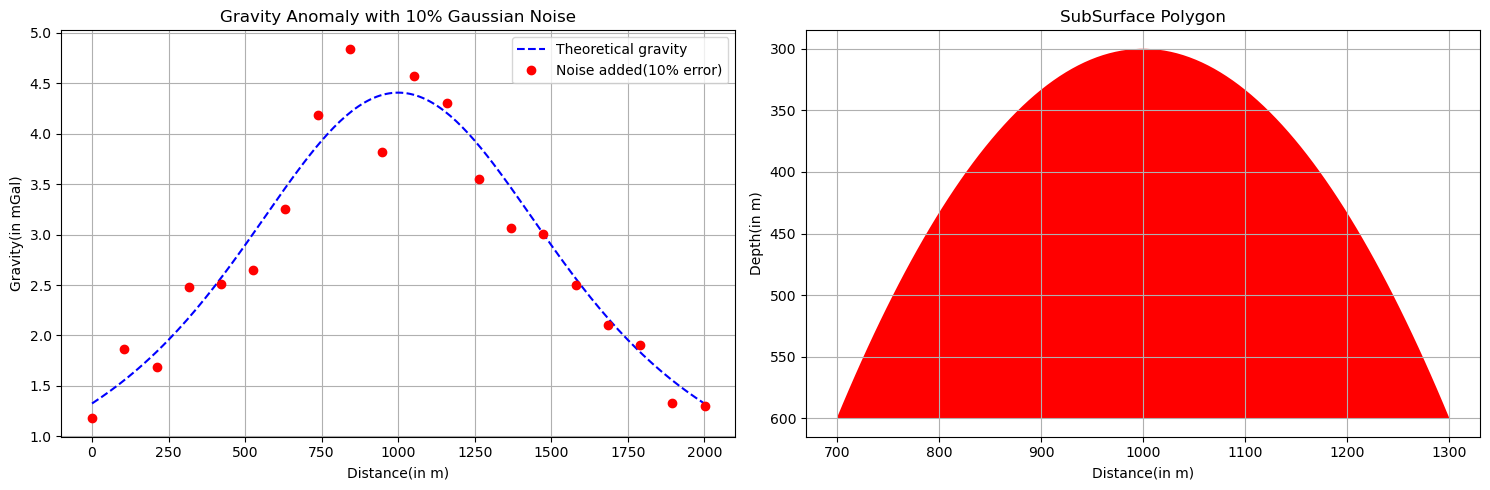

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def polygon_gravity(x_obs, polygon_vertices, density_contrast):
    gamma = 6.67e-11
    si2mgal = 1e5
    rho = density_contrast*1000

    xv,zv = polygon_vertices[:,0],polygon_vertices[:,1]
    grav= np.zeros_like(x_obs)

    for i in range (len(xv)):
        x1,z1 = xv[i], zv[i]
        x2,z2 = xv[(i+1)%len(xv)], zv[(i+1)%len(zv)]

        dx = x2-x1
        dz = z2-z1
        r1_sq = (x_obs - x1)**2 + z1**2
        r2_sq = (x_obs - x2)**2 + z2**2
        
        term = dz*np.log(r2_sq/r1_sq) - 2*dx*(np.arctan2(z2,x_obs-x2) - np.arctan2(z1,x_obs-x1))
        grav += term *2*gamma*rho

    return -grav*si2mgal

#PARAMETER
x_center = 1000
width = 600
top_depth = 300
max_depth = 600

#CREATE PARABOLA POINTS
x_top = np.linspace (x_center - width/2, x_center + width/2, 100)
z_top = top_depth + (max_depth - top_depth) * ((x_top - x_center)/(width/2))**2

#CREATE POLYGON VERTICES
x_poly = np.concatenate ([x_top, [x_center +width/2, x_center - width/2]])
z_poly = np.concatenate ([z_top, [max_depth, max_depth]])
polygon = np.column_stack((x_poly, z_poly))

#OBSERVATION POINTS
x_min,x_max = 0,2001
x_obs_fine = np.arange(x_min,x_max,10,dtype=np.float64)
x_obs_points = np.linspace(x_min,x_max,20)
density = 0.3

#GRAVITY CALCULATION
g_smooth = polygon_gravity(x_obs_fine,polygon,density)
g_true_points = polygon_gravity(x_obs_points,polygon,density)

#ADDING 10% GAUSSIAN NOISE
noise_magnitude = 0.1*np.abs(g_true_points)
g_noisy_points = g_true_points+np.random.normal(0,noise_magnitude)

'''#fixing the randon seed
np.random.seed(42)

#PSO Parameters
n_particles =5 
max_iter = 15
w=0.7
c1= 1.5
c2 = 1.5
target_error = 0.5 '''

#PLOTTING
plt.figure(figsize=(15,5))

#GRAVITY ANOMALY PLOT
plt.subplot(1,2,1)
plt.plot(x_obs_fine,g_smooth,'b--',label='Theoretical gravity')
plt.plot(x_obs_points,g_noisy_points,'ro',label='Noise added(10% error)')
plt.xlabel('Distance(in m)')
plt.ylabel('Gravity(in mGal)')
plt.title('Gravity Anomaly with 10% Gaussian Noise')
plt.legend()
plt.grid(True)

#SUBSURFACE POLYGON PLOT
plt.subplot(1,2,2)
poly_closed=np.vstack((polygon,polygon[0]))
plt.fill(poly_closed[:,0],poly_closed[:,1],'red',linewidth=2)
plt.xlabel('Distance(in m)')
plt.ylabel('Depth(in m)')
plt.title('SubSurface Polygon')
plt.gca().invert_yaxis()
plt.grid(True)

plt.tight_layout()
plt.show()


Iter 1: MSE = 0.1121
Iter 2: MSE = 0.0925
Iter 3: MSE = 0.0925
Iter 4: MSE = 0.0925
Iter 5: MSE = 0.0925
Iter 6: MSE = 0.0925
Iter 7: MSE = 0.0925
Iter 8: MSE = 0.0925
Iter 9: MSE = 0.0892
Iter 10: MSE = 0.0892
Iter 11: MSE = 0.0892
Iter 12: MSE = 0.0892
Iter 13: MSE = 0.0886
Iter 14: MSE = 0.0865
Iter 15: MSE = 0.0847
Iter 16: MSE = 0.0828
Iter 17: MSE = 0.0828
Iter 18: MSE = 0.0828
Iter 19: MSE = 0.0828
Iter 20: MSE = 0.0828


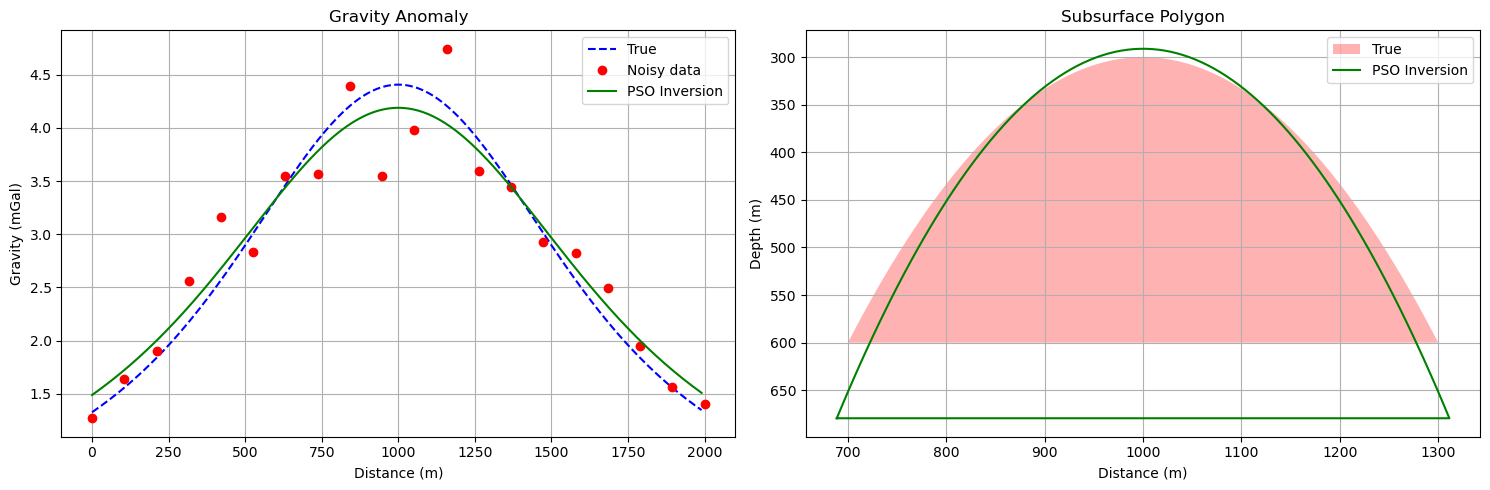

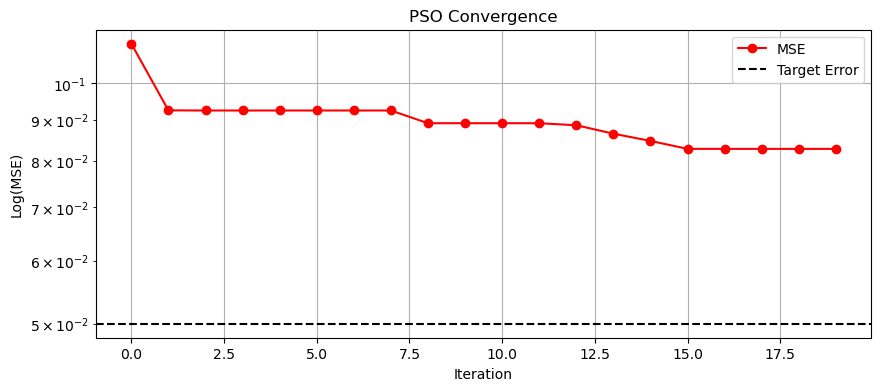


=== PSO RESULTS ===
Optimized parameters: width = 622.67, top_depth = 291.19, max_depth = 679.45
True parameters: width = 600, top_depth = 300, max_depth = 600
Final MSE: 0.082799


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def polygon_gravity(x_obs, polygon_vertices, density_contrast):
    gamma = 6.67e-11
    si2mgal = 1e5
    rho = density_contrast * 1000

    xv, zv = polygon_vertices[:, 0], polygon_vertices[:, 1]
    grav = np.zeros_like(x_obs, dtype=np.float64)  # Ensure float64 output

    for i in range(len(xv)):
        x1, z1 = xv[i], zv[i]
        x2, z2 = xv[(i + 1) % len(xv)], zv[(i + 1) % len(zv)]

        dx = x2 - x1
        dz = z2 - z1
        r1_sq = (x_obs - x1)**2 + z1**2
        r2_sq = (x_obs - x2)**2 + z2**2
        
        term = dz * np.log(r2_sq / r1_sq) - 2 * dx * (np.arctan2(z2, x_obs - x2) - np.arctan2(z1, x_obs - x1))
        grav += term * 2 * gamma * rho

    return -grav * si2mgal

# True parameters
x_center_true = 1000
width_true = 600
top_depth_true = 300
max_depth_true = 600

# Create true polygon
x_top_true = np.linspace(x_center_true - width_true / 2, x_center_true + width_true / 2, 100)
z_top_true = top_depth_true + (max_depth_true - top_depth_true) * ((x_top_true - x_center_true) / (width_true / 2))**2
x_poly_true = np.concatenate([x_top_true, [x_center_true + width_true / 2, x_center_true - width_true / 2]])
z_poly_true = np.concatenate([z_top_true, [max_depth_true, max_depth_true]])
true_polygon = np.column_stack((x_poly_true, z_poly_true))

# Observation points (FIXED: Force float64)
x_min, x_max = 0, 2000
x_obs_fine = np.arange(x_min, x_max, 10, dtype=np.float64)  # Critical fix
x_obs_points = np.linspace(x_min, x_max, 20, dtype=np.float64)
density = 0.3

# True gravity (synthetic data)
g_true = polygon_gravity(x_obs_points, true_polygon, density)
noise = 0.1 * np.abs(g_true) * np.random.normal(0, 1, len(g_true))
g_noisy = g_true + noise

# PSO parameters
n_particles = 15
max_iter = 20
w = 0.7
c1 = 1.5
c2 = 1.5
target_error = 0.05

# Bounds for parameters: [width, top_depth, max_depth]
lb = np.array([400, 200, 400], dtype=np.float64)  # Lower bounds
ub = np.array([800, 400, 800], dtype=np.float64)  # Upper bounds

# Initialize swarm
particles = np.random.uniform(lb, ub, (n_particles, 3))
velocities = np.zeros((n_particles, 3), dtype=np.float64)
pbest_positions = particles.copy()
pbest_scores = np.full(n_particles, np.inf)
gbest_position = None
gbest_score = np.inf
error_history = []

def create_polygon(params):
    width, top_depth, max_depth = params
    x_top = np.linspace(x_center_true - width / 2, x_center_true + width / 2, 100, dtype=np.float64)
    z_top = top_depth + (max_depth - top_depth) * ((x_top - x_center_true) / (width / 2))**2
    x_poly = np.concatenate([x_top, [x_center_true + width / 2, x_center_true - width / 2]])
    z_poly = np.concatenate([z_top, [max_depth, max_depth]])
    return np.column_stack((x_poly, z_poly))

def evaluate(params):
    polygon = create_polygon(params)
    g_pred = polygon_gravity(x_obs_points, polygon, density)
    return np.mean((g_pred - g_noisy)**2)  # MSE

# PSO main loop
for iteration in range(max_iter):
    for i in range(n_particles):
        score = evaluate(particles[i])
        
        if score < pbest_scores[i]:
            pbest_scores[i] = score
            pbest_positions[i] = particles[i].copy()
        
        if score < gbest_score:
            gbest_score = score
            gbest_position = particles[i].copy()
    
    for i in range(n_particles):
        r1, r2 = np.random.rand(2)
        velocities[i] = (w * velocities[i] +
                         c1 * r1 * (pbest_positions[i] - particles[i]) +
                         c2 * r2 * (gbest_position - particles[i]))
        particles[i] = np.clip(particles[i] + velocities[i], lb, ub)
    
    error_history.append(gbest_score)
    print(f"Iter {iteration + 1}: MSE = {gbest_score:.4f}")

    if gbest_score <= target_error:
        print(f"Target error reached at iteration {iteration + 1}.")
        break

# Optimized polygon
optimized_polygon = create_polygon(gbest_position)

# Predicted gravity (NOW WORKS)
g_pred = polygon_gravity(x_obs_fine, optimized_polygon, density)

# Plot results
plt.figure(figsize=(15, 5))

# Gravity anomaly plot
plt.subplot(1, 2, 1)
plt.plot(x_obs_fine, polygon_gravity(x_obs_fine, true_polygon, density), 'b--', label='True')
plt.plot(x_obs_points, g_noisy, 'ro', label='Noisy data')
plt.plot(x_obs_fine, g_pred, 'g-', label='PSO Inversion')
plt.xlabel('Distance (m)')
plt.ylabel('Gravity (mGal)')
plt.title('Gravity Anomaly')
plt.legend()
plt.grid(True)

# Polygon plot
plt.subplot(1, 2, 2)
plt.fill(true_polygon[:, 0], true_polygon[:, 1], 'r', alpha=0.3, label='True')
plt.plot(optimized_polygon[:, 0], optimized_polygon[:, 1], 'g-', label='PSO Inversion')
plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
plt.title('Subsurface Polygon')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Convergence plot
plt.figure(figsize=(10, 4))
plt.semilogy(error_history, 'r-', marker='o', label='MSE')
plt.axhline(y=target_error, color='k', linestyle='--', label='Target Error')
plt.xlabel('Iteration')
plt.ylabel('Log(MSE)')
plt.title('PSO Convergence')
plt.legend()
plt.grid(True)
plt.show()

print("\n=== PSO RESULTS ===")
print(f"Optimized parameters: width = {gbest_position[0]:.2f}, top_depth = {gbest_position[1]:.2f}, max_depth = {gbest_position[2]:.2f}")
print(f"True parameters: width = {width_true}, top_depth = {top_depth_true}, max_depth = {max_depth_true}")
print(f"Final MSE: {gbest_score:.6f}")

Iter 1: MSE = 0.5150
Iter 2: MSE = 0.4745
Iter 3: MSE = 0.4745
Iter 4: MSE = 0.4681
Iter 5: MSE = 0.4597
Iter 6: MSE = 0.4501
Iter 7: MSE = 0.4356
Iter 8: MSE = 0.4356
Iter 9: MSE = 0.4158
Iter 10: MSE = 0.4076
Iter 11: MSE = 0.4020
Iter 12: MSE = 0.3988
Iter 13: MSE = 0.3961
Iter 14: MSE = 0.3961
Iter 15: MSE = 0.3961
Iter 16: MSE = 0.3934
Iter 17: MSE = 0.3918
Iter 18: MSE = 0.3918
Iter 19: MSE = 0.3884
Iter 20: MSE = 0.3871
Iter 21: MSE = 0.3861
Iter 22: MSE = 0.3852
Iter 23: MSE = 0.3843
Iter 24: MSE = 0.3841
Iter 25: MSE = 0.3813
Iter 26: MSE = 0.3808
Iter 27: MSE = 0.3784
Iter 28: MSE = 0.3772
Iter 29: MSE = 0.3759
Iter 30: MSE = 0.3741


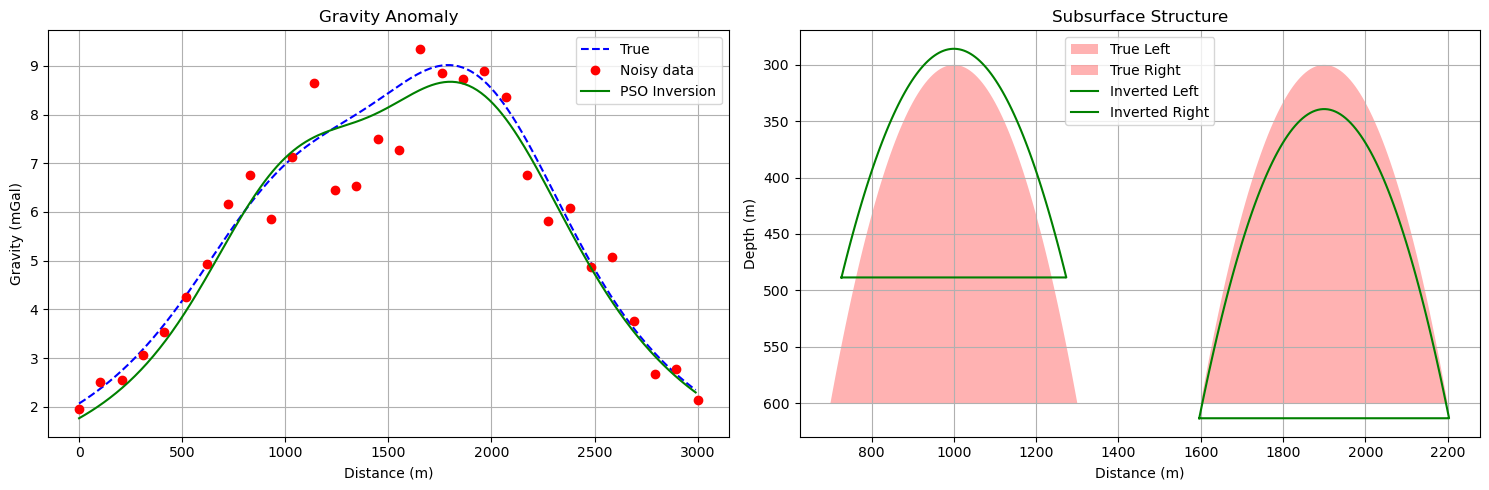

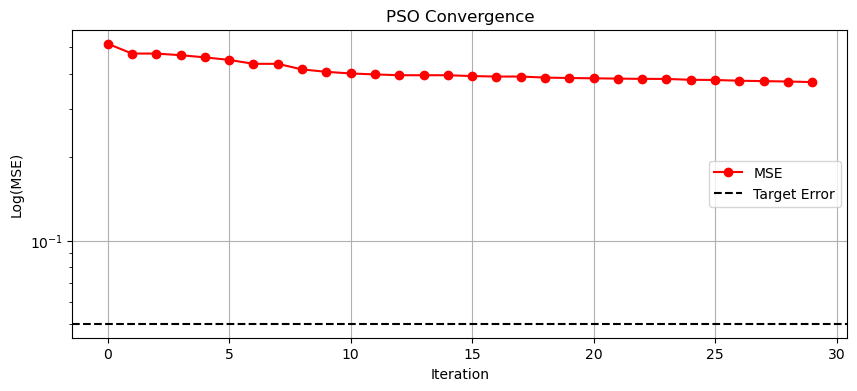


=== PSO RESULTS ===
Final MSE: 0.374095
Left parabola: width = 546.33, top = 285.76, bottom = 488.56
Right parabola: width = 607.24, top = 339.23, bottom = 613.43


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
gamma = 6.67e-11  # gravitational constant
si2mgal = 1e5

# Observation points
x_obs_fine = np.arange(0, 3000, 10, dtype=np.float64)
x_obs_points = np.linspace(0, 3000, 30, dtype=np.float64)

# Gravity from polygon

def polygon_gravity(x_obs, polygon_vertices, density_contrast):
    rho = density_contrast * 1000
    xv, zv = polygon_vertices[:, 0], polygon_vertices[:, 1]
    grav = np.zeros_like(x_obs, dtype=np.float64)

    for i in range(len(xv)):
        x1, z1 = xv[i], zv[i]
        x2, z2 = xv[(i + 1) % len(xv)], zv[(i + 1) % len(zv)]
        dx = x2 - x1
        dz = z2 - z1
        r1_sq = (x_obs - x1)**2 + z1**2
        r2_sq = (x_obs - x2)**2 + z2**2
        term = dz * np.log(r2_sq / r1_sq) - 2 * dx * (
            np.arctan2(z2, x_obs - x2) - np.arctan2(z1, x_obs - x1))
        grav += term * 2 * gamma * rho

    return -grav * si2mgal

# Create parabolic polygon
def create_parabola(center, width, top, bottom):
    x_top = np.linspace(center - width / 2, center + width / 2, 100)
    z_top = top + (bottom - top) * ((x_top - center) / (width / 2))**2
    x_poly = np.concatenate([x_top, [center + width / 2, center - width / 2]])
    z_poly = np.concatenate([z_top, [bottom, bottom]])
    return np.column_stack((x_poly, z_poly))

# True model parameters
x1_center_true, x2_center_true = 1000, 1900
width_true, top_depth_true, max_depth_true = 600, 300, 600

poly1_true = create_parabola(x1_center_true, width_true, top_depth_true, max_depth_true)
poly2_true = create_parabola(x2_center_true, width_true, top_depth_true, max_depth_true)

g_true = (polygon_gravity(x_obs_points, poly1_true, 0.3) +
          polygon_gravity(x_obs_points, poly2_true, 0.5))
noise = 0.1 * np.abs(g_true) * np.random.normal(0, 1, len(g_true))
g_noisy = g_true + noise

# PSO setup
n_particles, max_iter = 20, 30
w, c1, c2 = 0.7, 1.5, 1.5
target_error = 0.05

lb = np.array([400, 200, 400, 400, 200, 400])
ub = np.array([800, 400, 800, 800, 400, 800])

particles = np.random.uniform(lb, ub, (n_particles, 6))
velocities = np.zeros_like(particles)
pbest = particles.copy()
pbest_scores = np.full(n_particles, np.inf)
gbest = None
gbest_score = np.inf
error_history = []

def evaluate(params):
    width1, top1, max1, width2, top2, max2 = params
    p1 = create_parabola(x1_center_true, width1, top1, max1)
    p2 = create_parabola(x2_center_true, width2, top2, max2)
    g_pred = (polygon_gravity(x_obs_points, p1, 0.3) +
              polygon_gravity(x_obs_points, p2, 0.5))
    return np.mean((g_pred - g_noisy)**2)

# PSO loop
for iteration in range(max_iter):
    for i in range(n_particles):
        score = evaluate(particles[i])
        if score < pbest_scores[i]:
            pbest_scores[i] = score
            pbest[i] = particles[i].copy()
        if score < gbest_score:
            gbest_score = score
            gbest = particles[i].copy()

    for i in range(n_particles):
        r1, r2 = np.random.rand(2)
        velocities[i] = (w * velocities[i] +
                         c1 * r1 * (pbest[i] - particles[i]) +
                         c2 * r2 * (gbest - particles[i]))
        particles[i] = np.clip(particles[i] + velocities[i], lb, ub)

    error_history.append(gbest_score)
    print(f"Iter {iteration + 1}: MSE = {gbest_score:.4f}")
    if gbest_score <= target_error:
        print(f"Target error reached at iteration {iteration + 1}.")
        break

# Final model
p1_opt = create_parabola(x1_center_true, gbest[0], gbest[1], gbest[2])
p2_opt = create_parabola(x2_center_true, gbest[3], gbest[4], gbest[5])
g_pred = (polygon_gravity(x_obs_fine, p1_opt, 0.3) +
          polygon_gravity(x_obs_fine, p2_opt, 0.5))

# Plot gravity
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
true_total = (polygon_gravity(x_obs_fine, poly1_true, 0.3) +
              polygon_gravity(x_obs_fine, poly2_true, 0.5))
plt.plot(x_obs_fine, true_total, 'b--', label='True')
plt.plot(x_obs_points, g_noisy, 'ro', label='Noisy data')
plt.plot(x_obs_fine, g_pred, 'g-', label='PSO Inversion')
plt.xlabel('Distance (m)')
plt.ylabel('Gravity (mGal)')
plt.title('Gravity Anomaly')
plt.legend()
plt.grid(True)

# Plot subsurface
plt.subplot(1, 2, 2)
plt.fill(poly1_true[:, 0], poly1_true[:, 1], 'r', alpha=0.3, label='True Left')
plt.fill(poly2_true[:, 0], poly2_true[:, 1], 'r', alpha=0.3, label='True Right')
plt.plot(p1_opt[:, 0], p1_opt[:, 1], 'g-', label='Inverted Left')
plt.plot(p2_opt[:, 0], p2_opt[:, 1], 'g-', label='Inverted Right')
plt.gca().invert_yaxis()
plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
plt.title('Subsurface Structure')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Convergence plot
plt.figure(figsize=(10, 4))
plt.semilogy(error_history, 'r-', marker='o', label='MSE')
plt.axhline(y=target_error, color='k', linestyle='--', label='Target Error')
plt.xlabel('Iteration')
plt.ylabel('Log(MSE)')
plt.title('PSO Convergence')
plt.legend()
plt.grid(True)
plt.show()

print("\n=== PSO RESULTS ===")
print(f"Final MSE: {gbest_score:.6f}")
print(f"Left parabola: width = {gbest[0]:.2f}, top = {gbest[1]:.2f}, bottom = {gbest[2]:.2f}")
print(f"Right parabola: width = {gbest[3]:.2f}, top = {gbest[4]:.2f}, bottom = {gbest[5]:.2f}")


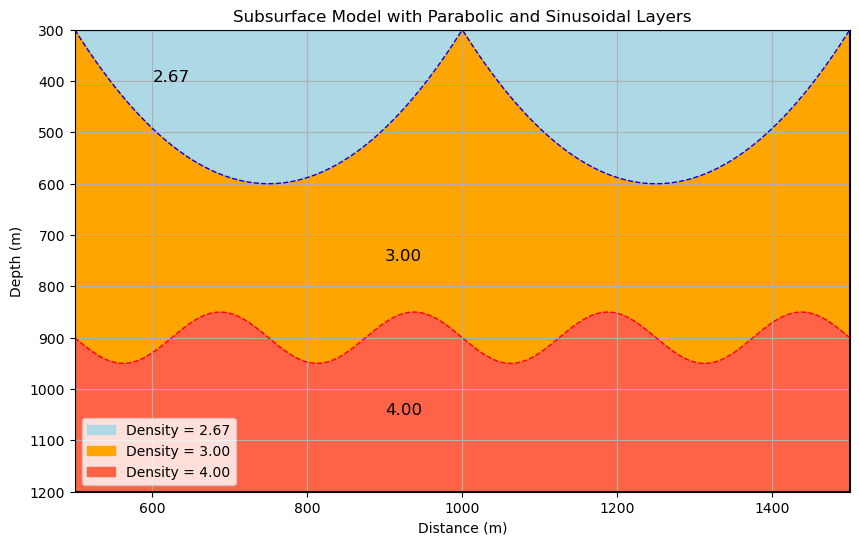

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define x domain
x = np.linspace(500, 1500, 500)

# Define top parabolic surfaces (from 300m to 600m)
y_parabola = np.piecewise(
    x,
    [x < 1000, x >= 1000],
    [
        lambda x: 600 - ((x - 750) ** 2) / (250 ** 2) * 300,  # Left parabola
        lambda x: 600 - ((x - 1250) ** 2) / (250 ** 2) * 300  # Right parabola
    ]
)

# Define sinusoidal interface (around 900 m depth)
y_wave = 900 + 50 * np.sin(2 * np.pi * (x - 500) / 250)  # Full wave every 250 m

# Set up plot
fig, ax = plt.subplots(figsize=(10, 6))

# Fill between top and parabola (uppermost layers)
ax.fill_between(x, 300, y_parabola, color='lightblue', label='Density = 2.67')

# Fill between parabola and wave (middle layer)
ax.fill_between(x, y_parabola, y_wave, color='orange', label='Density = 3.00')

# Fill below wave to 1200m (bottom layer)
ax.fill_between(x, y_wave, 1200, color='tomato', label='Density = 4.00')

# Draw boundary box
ax.plot([500, 500], [300, 1200], color='black')
ax.plot([1500, 1500], [300, 1200], color='black')
ax.plot([500, 1500], [300, 300], color='black')
ax.plot([500, 1500], [1200, 1200], color='black')

# Optional: plot interface lines (just for visual clarity)
ax.plot(x, y_parabola, color='blue', linestyle='--', linewidth=1)
ax.plot(x, y_wave, color='red', linestyle='--', linewidth=1)

# Annotations
ax.text(600, 400, '2.67', fontsize=12)
ax.text(900, 750, '3.00', fontsize=12)
ax.text(900, 1050, '4.00', fontsize=12)

# Axis settings
ax.set_xlim(500, 1500)
ax.set_ylim(1200, 300)  # Depth increases downward
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Depth (m)")
ax.set_title("Subsurface Model with Parabolic and Sinusoidal Layers")
ax.legend()
ax.grid(True)

plt.show()


Iter 1: MSE = 0.2833
Iter 2: MSE = 0.2829
Iter 3: MSE = 0.2829
Iter 4: MSE = 0.2829
Iter 5: MSE = 0.2829
Iter 6: MSE = 0.2829
Iter 7: MSE = 0.2829
Iter 8: MSE = 0.2829
Iter 9: MSE = 0.2829
Iter 10: MSE = 0.2829
Iter 11: MSE = 0.2829
Iter 12: MSE = 0.2829
Iter 13: MSE = 0.2829
Iter 14: MSE = 0.2829
Iter 15: MSE = 0.2829
Iter 16: MSE = 0.2829
Iter 17: MSE = 0.2829
Iter 18: MSE = 0.2829
Iter 19: MSE = 0.2829
Iter 20: MSE = 0.2829


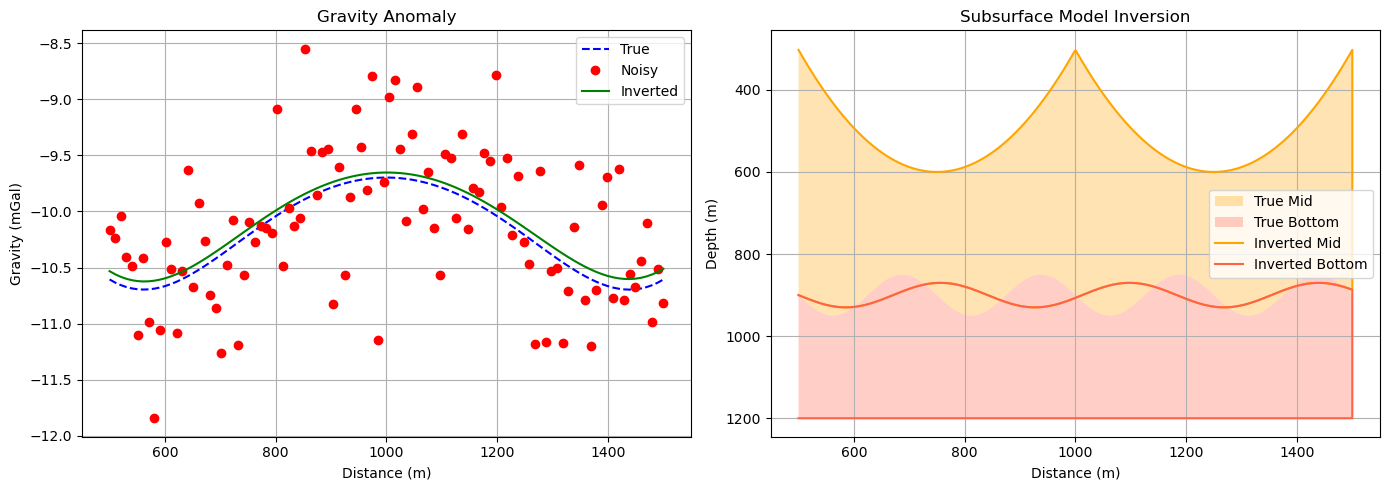

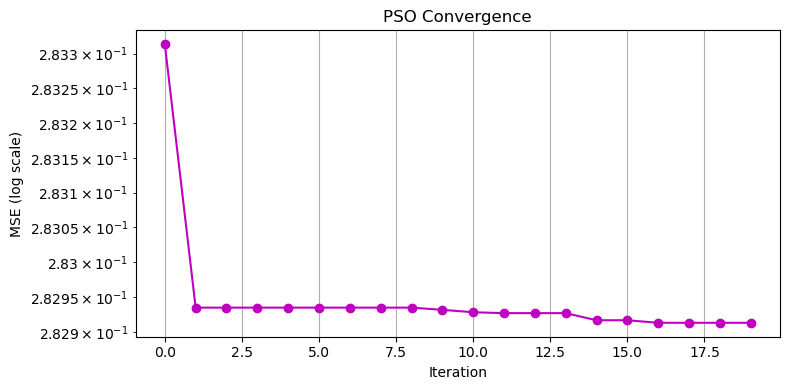


=== Final Parameters ===
Parabola Depth Scale: 297.48 m
Wave Amplitude: 29.88 m
Wave Wavelength: 341.56 m
Final MSE: 0.282913


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Constants
gamma = 6.67e-11
si2mgal = 1e5

# Define x domain
x = np.linspace(500, 1500, 500)

# Parabola and sinusoid for the model
def top_parabola(x):
    return np.where(
        x < 1000,
        600 - ((x - 750) ** 2) / (250 ** 2) * 300,
        600 - ((x - 1250) ** 2) / (250 ** 2) * 300
    )

def wave_interface(x):
    return 900 + 50 * np.sin(2 * np.pi * (x - 500) / 250)

# Generate model interfaces
y_top = np.full_like(x, 300)
y_parabola = top_parabola(x)
y_wave = wave_interface(x)
y_bottom = np.full_like(x, 1200)

# Observation points
x_obs = np.linspace(500, 1500, 100)

# Construct polygon layers
def construct_layer(x, top, bottom):
    return np.column_stack((np.concatenate([x, x[::-1]]),
                            np.concatenate([top, bottom[::-1]])))

layer1 = construct_layer(x, y_top, y_parabola)
layer2 = construct_layer(x, y_parabola, y_wave)
layer3 = construct_layer(x, y_wave, y_bottom)

# Gravity from polygon
def polygon_gravity(x_obs, polygon_vertices, density_contrast):
    rho = density_contrast * 1000
    xv, zv = polygon_vertices[:, 0], polygon_vertices[:, 1]
    grav = np.zeros_like(x_obs, dtype=np.float64)

    for i in range(len(xv)):
        x1, z1 = xv[i], zv[i]
        x2, z2 = xv[(i + 1) % len(xv)], zv[(i + 1) % len(zv)]
        dx = x2 - x1
        dz = z2 - z1
        r1_sq = (x_obs - x1)**2 + z1**2
        r2_sq = (x_obs - x2)**2 + z2**2
        term = dz * np.log(r2_sq / r1_sq) - 2 * dx * (
            np.arctan2(z2, x_obs - x2) - np.arctan2(z1, x_obs - x1))
        grav += term * 2 * gamma * rho

    return -grav * si2mgal

# True gravity and noisy data
g_true = (polygon_gravity(x_obs, layer2, 0.33) +
           polygon_gravity(x_obs, layer3, 1.00))
noise = 0.05 * np.abs(g_true) * np.random.normal(0, 1, len(g_true))
g_noisy = g_true + noise

# PSO setup
n_particles = 25
max_iter = 20
w, c1, c2 = 0.7, 1.5, 1.5
lb = np.array([200, 20, 200])  # [parabola_depth, wave_amp, wave_length]
ub = np.array([400, 80, 400])
particles = np.random.uniform(lb, ub, (n_particles, 3))
velocities = np.zeros_like(particles)
pbest = particles.copy()
pbest_scores = np.full(n_particles, np.inf)
gbest = None
gbest_score = np.inf
error_history = []

# Evaluate gravity for params
def evaluate(params):
    d, a, wl = params
    p = lambda x: np.where(
        x < 1000,
        600 - ((x - 750)**2 / (250**2)) * d,
        600 - ((x - 1250)**2 / (250**2)) * d
    )
    w = lambda x: 900 + a * np.sin(2 * np.pi * (x - 500) / wl)
    yp, yw = p(x), w(x)
    layer2_poly = construct_layer(x, yp, yw)
    layer3_poly = construct_layer(x, yw, y_bottom)
    g_pred = polygon_gravity(x_obs, layer2_poly, 0.33) + polygon_gravity(x_obs, layer3_poly, 1.00)
    return np.mean((g_pred - g_noisy)**2)

# PSO main loop
for it in range(max_iter):
    for i in range(n_particles):
        score = evaluate(particles[i])
        if score < pbest_scores[i]:
            pbest_scores[i] = score
            pbest[i] = particles[i].copy()
        if score < gbest_score:
            gbest_score = score
            gbest = particles[i].copy()

    for i in range(n_particles):
        r1, r2 = np.random.rand(2)
        velocities[i] = (w * velocities[i] +
                         c1 * r1 * (pbest[i] - particles[i]) +
                         c2 * r2 * (gbest - particles[i]))
        particles[i] = np.clip(particles[i] + velocities[i], lb, ub)

    error_history.append(gbest_score)
    print(f"Iter {it + 1}: MSE = {gbest_score:.4f}")

# Rebuild inverted model from best params
d_opt, a_opt, wl_opt = gbest
p_inv = lambda x: np.where(
    x < 1000,
    600 - ((x - 750)**2 / (250**2)) * d_opt,
    600 - ((x - 1250)**2 / (250**2)) * d_opt
)
w_inv = lambda x: 900 + a_opt * np.sin(2 * np.pi * (x - 500) / wl_opt)
yp_inv, yw_inv = p_inv(x), w_inv(x)
layer2_inv = construct_layer(x, yp_inv, yw_inv)
layer3_inv = construct_layer(x, yw_inv, y_bottom)
g_pred = polygon_gravity(x_obs, layer2_inv, 0.33) + polygon_gravity(x_obs, layer3_inv, 1.00)

# Plot Gravity Anomaly
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(x_obs, g_true, 'b--', label='True')
plt.plot(x_obs, g_noisy, 'ro', label='Noisy')
plt.plot(x_obs, g_pred, 'g-', label='Inverted')
plt.xlabel("Distance (m)")
plt.ylabel("Gravity (mGal)")
plt.title("Gravity Anomaly")
plt.legend()
plt.grid(True)

# Plot Subsurface Model
plt.subplot(1, 2, 2)
plt.fill(layer2[:, 0], layer2[:, 1], 'orange', alpha=0.3, label='True Mid')
plt.fill(layer3[:, 0], layer3[:, 1], 'tomato', alpha=0.3, label='True Bottom')
plt.plot(layer2_inv[:, 0], layer2_inv[:, 1], 'orange', label='Inverted Mid')
plt.plot(layer3_inv[:, 0], layer3_inv[:, 1], 'tomato', label='Inverted Bottom')
plt.gca().invert_yaxis()
plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.title("Subsurface Model Inversion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# PSO Convergence
plt.figure(figsize=(8, 4))
plt.semilogy(error_history, 'm-o')
plt.xlabel("Iteration")
plt.ylabel("MSE (log scale)")
plt.title("PSO Convergence")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== Final Parameters ===")
print(f"Parabola Depth Scale: {d_opt:.2f} m")
print(f"Wave Amplitude: {a_opt:.2f} m")
print(f"Wave Wavelength: {wl_opt:.2f} m")
print(f"Final MSE: {gbest_score:.6f}")